In [ ]:
# https://pytorch-geometric.readthedocs.io/en/2.6.1/get_started/introduction.html
# Author: Ziang Li. 08/28/2025

In [ ]:
! pip install torch==2.7.1+cu128 torchvision==0.22.1+cu128 torchaudio==2.7.1+cu128 \
  --extra-index-url https://download.pytorch.org/whl/cu128
! pip install torch_geometric



In [ ]:
# adapt from https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8?usp=sharing#scrollTo=zF5bw3m9UrMy
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt


def visualize_graph(G, color):
    plt.figure(figsize=(5,5))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

# How to Construct a graph

<div style="background-color:white; display:inline-block;">
  <img src="https://pytorch-geometric.readthedocs.io/en/2.6.1/_images/graph.svg" width="400">
</div>
We show a simple example of an unweighted and undirected graph with three nodes and four edges. Each node contains exactly one feature:


In [ ]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)
data

Data(x=[3, 1], edge_index=[2, 4])

Data is just a data structure, we can store almost everything in it.

In [ ]:
import numpy as np
data.label1 = [1,2,3]
data.label2 = [1,1,1]
data.label3 = [1,2,2]

We can construct a graph from an adjacency matrix.

/usr/local/lib/python3.12/dist-packages/networkx/drawing/nx_pylab.py:1438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


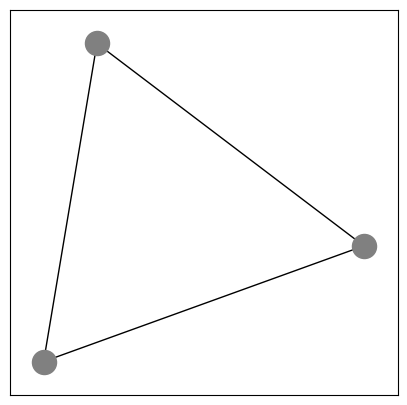

In [ ]:
A = np.array([[0,1,1],
              [1,0,1],
              [1,1,0]])
G = nx.from_numpy_array(A)
# show G
visualize_graph(G, color='gray')

Note that we stored different labels in data.

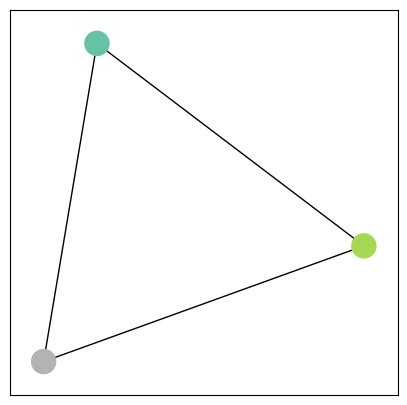

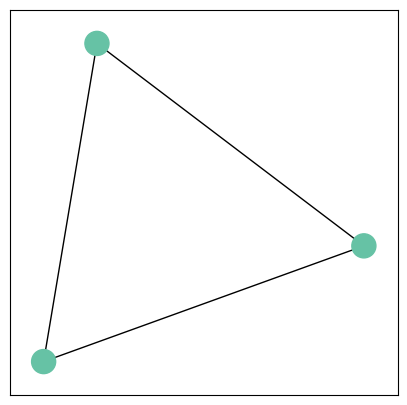

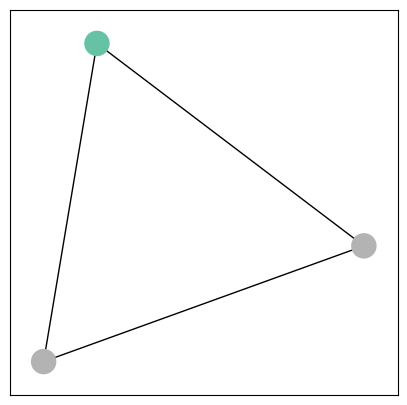

In [ ]:
for label in ['label1', 'label2', 'label3']:
  visualize_graph(G, data[label])

The Data object also comes with a number of built-in methods (e.g., checking for isolated nodes, self-loops, or directed edges). These methods use the stored tensors as input and let you interact with the Data object much like a real graph.

In [ ]:
print(data.num_nodes)

print(data.has_isolated_nodes())

print(data.has_self_loops())

print(data.is_directed())

# # Transfer data object to GPU.
# device = torch.device('cuda')
# data = data.to(device)

3
False
False
False


We can implement these methods by ourselves

In [ ]:
def has_isolated_nodes(data):
    edge_index = data.edge_index
    num_nodes = len(data.y)
    connected_nodes = torch.unique(edge_index.flatten())
    return connected_nodes.numel() < num_nodes
has_isolated_nodes(data)


False

Data only stores tensors (nodes/edges), ***not a full graph***. We can use data.validate to check if this is a validate graph, with given features. ***Note that the next cell will raise ValueError***.

In [ ]:
import torch
from torch_geometric.data import Data
# there is no node 10 in x
edge_index = torch.tensor([[0, 1, 1, 10],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)
data.validate(raise_on_error=True)

ValueError: 'edge_index' contains larger indices than the number of nodes (3) in 'Data' (found 10)

# Train your first GNN

In [ ]:
# adapt from https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX?usp=sharing#scrollTo=F1op-CbyLuN4
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2,perplexity=20).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(5,5))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=35, c=color, cmap="Set2")
    plt.show()

Cora dataset. A network for scientific publications. Visit https://graphsandnetworks.com/the-cora-dataset/ for a visualization.
Let's see how many nodes, edges, and classes are there.

In [ ]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')
dataset.data.num_nodes, dataset.data.num_edges, dataset.num_classes

/usr/local/lib/python3.12/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


(2708, 10556, 7)

Some features we usually care about when we first see a dataset

In [ ]:
data = dataset.data
print(data.has_isolated_nodes())

print(data.has_self_loops())

print(data.is_directed())

False
False
False


/usr/local/lib/python3.12/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


For a node classification task, let's use GCN. https://tkipf.github.io/graph-convolutional-networks/ . `nn.GCNConv` is a basic block in `pyg`, like the `nn.linear` in `torch`.

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)
gcn = GCN()
print(gcn)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gcn = gcn.to(device)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


Train the model

In [ ]:
def train_model(model, data):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data = data.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    model.eval()
    with torch.no_grad():
      output_before_train = model(data)
    model.train()

    # ===== Training loop =====
    for epoch in range(200):
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

    # ===== Evaluation =====
    model.eval()
    output_after_train = model(data)
    pred = output_after_train.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    print(f'Accuracy: {acc:.4f}')
    return output_before_train, output_after_train


In [ ]:
output_before_train, output_after_train = train_model(GCN().to(device), dataset)

Accuracy: 0.8030


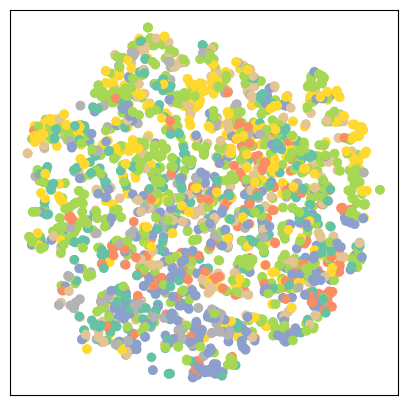

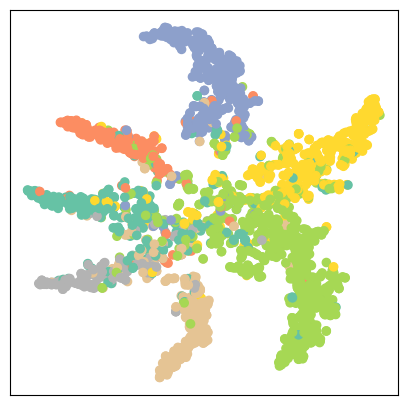

(None, None)

In [ ]:
visualize(output_before_train, data.y), visualize(output_after_train, data.y)

We start with a simple implementation of the **GCN update rule**.  
This layer will:  
1. Add self-loops  
2. Compute normalized messages  
3. Aggregate neighbor features  
4. Apply a linear transformation  

---

### GCN update rule

The update rule for a node $i$ in Graph Convolutional Networks (GCNs) is:

$$
h_i^{(l+1)} = \sigma \left( \sum_{j \in \mathcal{N}(i) \cup \{i\}} \frac{1}{d_i} \, W \, h_j^{(l)} \right)
$$

where:  
- $h_i^{(l)}$: feature of node $i$ at layer $l$  
- $\mathcal{N}(i)$: neighbors of node $i$  
- $d_i$: degree of node $i$ (including self-loop)  
- $W$: learnable weight matrix  
- $\sigma$: activation function (e.g., ReLU)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import add_self_loops, degree

class SimpleMessagePassing(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.linear = nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        num_nodes = x.size(0)

        # Add self-loops to each node
        edge_index, _ = add_self_loops(edge_index, num_nodes=num_nodes)

        row, col = edge_index  # row: target nodes, col: source nodes

        # Compute node degrees (number of incoming edges per node)
        deg = degree(row, num_nodes=num_nodes, dtype=x.dtype)  # shape: [num_nodes]
        deg_inv = deg.pow(-1)  # D^(-1)
        deg_inv[deg_inv == float('inf')] = 0  # handle divide-by-zero

        # Normalize the messages with D^(-1)
        norm = deg_inv[row]  # shape: [num_edges]

        # Compute messages sent along edges
        messages = norm.unsqueeze(1) * x[col]  # shape: [num_edges, in_channels]
        # Initialize aggregated output
        out = torch.zeros_like(x)  # shape: [num_nodes, in_channels]
        # Aggregate messages from neighbors
        out = out.index_add(0, row, messages)

        # Apply linear transformation
        return self.linear(out)

class SimpleGCN(nn.Module):
    def __init__(self, dataset, hidden=16):
        super().__init__()
        self.conv1 = SimpleMessagePassing(dataset.num_node_features, hidden)
        self.conv2 = SimpleMessagePassing(hidden, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)  # for classification



In [ ]:
# ===== Training setup =====
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleGCN(dataset).to(device)
output_before_train, output_after_train =  train_model(model, data)

Accuracy: 0.8020


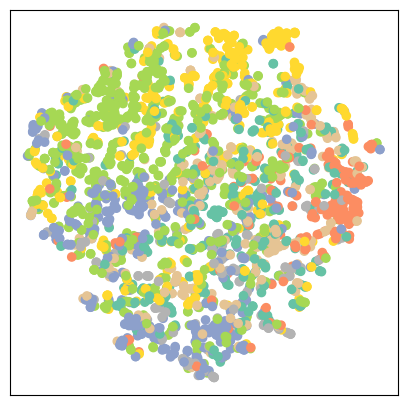

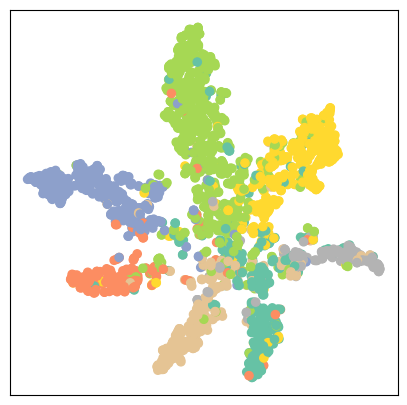

(None, None)

In [ ]:
visualize(output_before_train, data.y), visualize(output_after_train, data.y)